<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Approach" data-toc-modified-id="Approach-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Approach</a></span></li><li><span><a href="#Angular-Momentum" data-toc-modified-id="Angular-Momentum-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Angular Momentum</a></span></li></ul></div>

# Motorcycle Gyroscopic Effects

## Introduction
While it is technically possible for a bicycle or motorcycle to self-stabilize in the absense of gyroscopic effects from the spinning wheels (see [Koojiman et al.,  2011](https://www.science.org/doi/10.1126/science.1201959)), eliminating gyroscopic effects from most 'normal' bicycle or motorcycle designs will have drastic effects on their eigenvalues, even for small light two-wheelers with small wheels. Below, see how the eigenvalues of the [fourth order model](./fourth_order_model.ipynb) of Lafayette College's Razor MX350 minibike change when gyroscopic effects are excluded.

(0.0, 10.0, -30.0, 30.0)

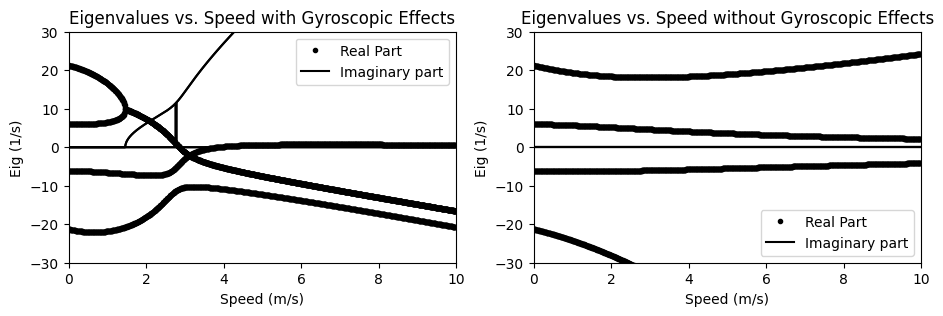

In [4]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import control 

def getModelMDK (U,printmodel=False):
    a = .3386#meters, distance from rear axle to CG in x direction
    b = .767#meters, wheelbase of bike
    c = .023#.08#meters, trail
    hrf = .25606#meters, rear frame CG height
    mrf = 11.065#kg, rear frame mass inc. rider
    xff = .62218#position of front frame CG
    yff = 0#y-position of the front frame CG
    zff = .46531#height of the front frame CG
    mff = 2.2047 #kg, fork mass
    Rfw = .15875 #m, radius of the front wheel
    mfw = 1.486 #kg, wheel mass
    Rrw = 0.15875 # radius of real wheel
    mrw = 2.462 #mass of rear wheel
    mr = mrw+mrf #mass of rear frame includes rear wheel
    hr = (mrf*hrf+mrw*Rrw)/(mr) #CG height of rear frame includes rear wheel
    Jyyf = 0.020502342#mfw*Rfw**2
    Jyyr = 0.033968214#mrw*Rrw**2
    Sf = Jyyf/Rfw
    Sr = Jyyr/Rrw
    St = Sf+Sr
    mf = mff+mfw #total mass of front frame includes front wheel
    xf = (mff*xff+b*mfw)/mf# total front frame x position including front wheel
    hf = (zff*mff+Rfw*mfw)/mf #total front frame mass height including front wheel
    lam = 1.16 #radians, angle from negative x axis to steering axis
    g = 9.81 #m/s/s, graUitational constant
    u = hf*cos(lam)-(b+c-xf)*sin(lam) #perpendicular distance from steer axis to front frame CG (positive if CG in front of steer axis)
    
    #build terms for the MDK model based on Eqn32
    M11 = mr*hr**2 + mf*hf**2
    M12 = -mf*hf*u- c*sin(lam)/b*(mf*xf*hf+mr*hr*a)
    M21 = -mf*hf*u- c*sin(lam)/b*(mf*xf*hf+mr*hr*a)
    M22 = mf*(u**2+2*c*sin(lam)/b*xf*u)+c**2*sin(lam)**2/b**2*(mr*a**2+mf*xf**2)
    D11 = 0
    D12 = U*sin(lam)/b*(-mr*hr*a - mf*xf*hf)-U*c*sin(lam)/b*(mf*hf+mr*hr)-U*c*sin(lam)/b*(Jyyf/Rfw+Jyyr/Rrw)-U*Jyyf/Rfw*sin(lam)
    D21 = U*c*sin(lam)/b*(Jyyf/Rfw+Jyyr/Rrw)+Jyyf/Rfw*U*sin(lam)
    D22 = U*sin(lam)/b*mf*xf*u + U*c*sin(lam)**2/b**2*(mr*a**2+mf*xf**2)+U*c*sin(lam)/b*mf*u+U*c**2*sin(lam)**2/b**2*(mf*xf+mr*a)
    K11 = -(mr*g*hr+mf*g*hf)
    K12 = mf*g*u+g*c*sin(lam)/b*(mf*xf+mr*a)-U**2*sin(lam)/b*(mf*hf+mr*hr)-U**2*sin(lam)/b*(Jyyf/Rfw+Jyyr/Rrw)
    K21 = mf*g*u + g*c*sin(lam)/b*(mr*a+mf*xf)
    K22 = -mf*g*u-g*c*sin(lam)*cos(lam)/b*(mr*a+mf*xf) + U**2*sin(lam)/b*mf*u+U**2*c*sin(lam)**2/b**2*(mf*xf+mr*a) + Jyyf/Rfw*U**2*sin(lam)/b
    
    M = array([[M11, M12],[M21, M22]])
    D = array([[D11, D12],[D21, D22]])
    K = array([[K11, K12],[K21, K22]])
    
    return M,D,K,eye(2)
    

def getModelSS(v):
    #first get the model in MDK form
    M,D,K,F = getModelMDK(v)
    A = hstack((zeros((2,2)),eye(2,2)))#first create the 'top half' of A matrix
    A = vstack((A,hstack((dot(-linalg.inv(M),K),dot(-linalg.inv(M),D)))))# now fill in bottom half
    B = vstack((zeros((2,2)),dot(linalg.inv(M),F)))#now stack zeros on top of our M^-1F term
    C = array([[1,0,0,0],[0,1,0,0]]) #choose the 'outputs' as just roll and steer
    D = zeros((2,2)) #with two possible inputs, two possible outputs, there are four terms in the D matrix when output eqn is y = Cx+Du
    sys = control.StateSpace(A,B,C,D)
    return sys

def getModelMDKNoGyro (U,printmodel=False):
    a = .3386#meters, distance from rear axle to CG in x direction
    b = .767#meters, wheelbase of bike
    c = .023#.08#meters, trail
    hrf = .25606#meters, rear frame CG height
    mrf = 11.065#kg, rear frame mass inc. rider
    xff = .62218#position of front frame CG
    yff = 0#y-position of the front frame CG
    zff = .46531#height of the front frame CG
    mff = 2.2047 #kg, fork mass
    Rfw = .15875 #m, radius of the front wheel
    mfw = 1.486 #kg, wheel mass
    Rrw = 0.15875 # radius of real wheel
    mrw = 2.462 #mass of rear wheel
    mr = mrw+mrf #mass of rear frame includes rear wheel
    hr = (mrf*hrf+mrw*Rrw)/(mr) #CG height of rear frame includes rear wheel
    Jyyf = 0#0.020502342#mfw*Rfw**2
    Jyyr = 0#0.033968214#mrw*Rrw**2
    Sf = Jyyf/Rfw
    Sr = Jyyr/Rrw
    St = Sf+Sr
    mf = mff+mfw #total mass of front frame includes front wheel
    xf = (mff*xff+b*mfw)/mf# total front frame x position including front wheel
    hf = (zff*mff+Rfw*mfw)/mf #total front frame mass height including front wheel
    lam = 1.16 #radians, angle from negative x axis to steering axis
    g = 9.81 #m/s/s, graUitational constant
    u = hf*cos(lam)-(b+c-xf)*sin(lam) #perpendicular distance from steer axis to front frame CG (positive if CG in front of steer axis)
    
    #build terms for the MDK model based on Eqn32
    M11 = mr*hr**2 + mf*hf**2
    M12 = -mf*hf*u- c*sin(lam)/b*(mf*xf*hf+mr*hr*a)
    M21 = -mf*hf*u- c*sin(lam)/b*(mf*xf*hf+mr*hr*a)
    M22 = mf*(u**2+2*c*sin(lam)/b*xf*u)+c**2*sin(lam)**2/b**2*(mr*a**2+mf*xf**2)
    D11 = 0
    D12 = U*sin(lam)/b*(-mr*hr*a - mf*xf*hf)-U*c*sin(lam)/b*(mf*hf+mr*hr)-U*c*sin(lam)/b*(Jyyf/Rfw+Jyyr/Rrw)-U*Jyyf/Rfw*sin(lam)
    D21 = U*c*sin(lam)/b*(Jyyf/Rfw+Jyyr/Rrw)+Jyyf/Rfw*U*sin(lam)
    D22 = U*sin(lam)/b*mf*xf*u + U*c*sin(lam)**2/b**2*(mr*a**2+mf*xf**2)+U*c*sin(lam)/b*mf*u+U*c**2*sin(lam)**2/b**2*(mf*xf+mr*a)
    K11 = -(mr*g*hr+mf*g*hf)
    K12 = mf*g*u+g*c*sin(lam)/b*(mf*xf+mr*a)-U**2*sin(lam)/b*(mf*hf+mr*hr)-U**2*sin(lam)/b*(Jyyf/Rfw+Jyyr/Rrw)
    K21 = mf*g*u + g*c*sin(lam)/b*(mr*a+mf*xf)
    K22 = -mf*g*u-g*c*sin(lam)*cos(lam)/b*(mr*a+mf*xf) + U**2*sin(lam)/b*mf*u+U**2*c*sin(lam)**2/b**2*(mf*xf+mr*a) + Jyyf/Rfw*U**2*sin(lam)/b
    
    M = array([[M11, M12],[M21, M22]])
    D = array([[D11, D12],[D21, D22]])
    K = array([[K11, K12],[K21, K22]])
    
    return M,D,K,eye(2)
    

def getModelSSNoGyro(v):
    #first get the model in MDK form
    M,D,K,F = getModelMDKNoGyro(v)
    A = hstack((zeros((2,2)),eye(2,2)))#first create the 'top half' of A matrix
    A = vstack((A,hstack((dot(-linalg.inv(M),K),dot(-linalg.inv(M),D)))))# now fill in bottom half
    B = vstack((zeros((2,2)),dot(linalg.inv(M),F)))#now stack zeros on top of our M^-1F term
    C = array([[1,0,0,0],[0,1,0,0]]) #choose the 'outputs' as just roll and steer
    D = zeros((2,2)) #with two possible inputs, two possible outputs, there are four terms in the D matrix when output eqn is y = Cx+Du
    sys = control.StateSpace(A,B,C,D)
    return sys


#create a vector of velocities to investigate
vvec = arange(.01,10,.01)
#create a second copy of this vector that is four rows. This will make plotting easier
vvec2 = zeros((4,len(vvec)))
vvec2ng = zeros((4,len(vvec)))

#our model is fourth order, so will have 4 eigenvalues. each can have a real and/or imaginary part.
eigs_re = zeros((4,len(vvec)))
eigs_im = zeros((4,len(vvec)))
eigs_re_ng = zeros((4,len(vvec)))
eigs_im_ng = zeros((4,len(vvec)))

for k in range(0,len(vvec)):
    #get current velocity
    v = vvec[k]
    #get state space model at this speed
    sys= getModelSS(v)
    sysng = getModelSSNoGyro(v)
    #get eigenvalues at this speed
    eigs,vecs = linalg.eig(sys.A)
    eigsng,vecsng = linalg.eig(sysng.A)
    #get real parts and place in proper matrix for storage
    eigs_re[:,k] = real(eigs)
    eigs_re_ng[:,k] = real(eigsng)
    #get imaginary parts and place in proper matrix for storage
    eigs_im[:,k] = imag(eigs)
    eigs_im_ng[:,k] = imag(eigsng)
    #fill up velocity vector corresponding with each eigenvalue
    vvec2[:,k] = [v,v,v,v]
    vvec2ng[:,k] = [v,v,v,v]

#creat a figure for us to plot the eigenvalues.
figure(figsize=(11,3))
subplot(1,2,1)
plot(vvec,eigs_re[0,:],'k.',vvec,eigs_im[0,:],'k')
xlabel('Speed (m/s)')
ylabel('Eig (1/s)')
legend(['Real Part','Imaginary part'])
plot(vvec,eigs_re[1,:],'k.',vvec,abs(eigs_im[1,:]),'k')
plot(vvec,eigs_re[2,:],'k.',vvec,abs(eigs_im[2,:]),'k')
plot(vvec,eigs_re[3,:],'k.',vvec,abs(eigs_im[3,:]),'k')
#limit our view so we can see what's happening
axis([0,10,-30,30])
title('Eigenvalues vs. Speed with Gyroscopic Effects')
subplot(1,2,2)
plot(vvec,eigs_re_ng[0,:],'k.',vvec,eigs_im_ng[0,:],'k')
xlabel('Speed (m/s)')
ylabel('Eig (1/s)')
legend(['Real Part','Imaginary part'])
plot(vvec,eigs_re_ng[1,:],'k.',vvec,abs(eigs_im_ng[1,:]),'k')
plot(vvec,eigs_re_ng[2,:],'k.',vvec,abs(eigs_im_ng[2,:]),'k')
plot(vvec,eigs_re_ng[3,:],'k.',vvec,abs(eigs_im_ng[3,:]),'k')
title('Eigenvalues vs. Speed without Gyroscopic Effects')
#limit our view so we can see what's happening
axis([0,10,-30,30])

as you can see, without the gyroscopic effects from the wheels (which are only around 12" in diameter including tires!), the minibike is *never* self-stable, because there is no speed at which all four of the eigenvalues' real parts are less than zero. With gyroscopic effects, the 4th-order Whipple model predicts that the Razor has a small window of self-stabilizing speeds between just over 3 m/s and just below 4 m/s.

## Approach

This notebook will walk through where gyroscopic effects on motorcycle stability come from. The expressions for gyroscopic torque that we develop here will be incorporated into the derivation of the [fourth order model](./fourth_order_model.ipynb) of motorcycle dynamics by including them as "non-conservative torques" in Lagrange's equations. Especially if you have some background in physics, you might balk at the idea of treating gyroscopic reactions as "non-conservative," since they arise from the conservation of angular momentum, and in the absense of friction, an idealized gyroscope will certainly satisfy the first law of thermodynamics, even if the direction of angular velocities change.

However, in the fourth order Whipple-style model of motorcycle dynamics, the system's energetic boundary only includes motion in the bike's yaw, roll, and steer directions. The angular momentum of a motorcycle's front or rear wheel is actually a result of the bike's forward ($\hat{\imath}$) motion, which is assumed constant in the Whipple model. This means that the spin motion of the front and rear wheels is an "infinite well" of power, so the gyroscopic effects can technically cause energy to cross into or out of the system's boundary, acting potentially as a "source" or a "sink" of energy.

In the remaining sections, we will use the [conservation of angular momentum](https://en.wikipedia.org/wiki/Angular_momentum) to derive the reaction torques that must be present in order for changes in the wheels' directions to occur using the rotational form of Newton's Second Law for a rigid body:

\begin{equation}
\left. \frac{d \vec{H}}{dt}\right|_g = \sum \vec{T}_g
\end{equation}

where "g" denotes "about a body's center of mass. The idea here is that as the bike rolls, yaws, and steers, the rear and front frames of the bike exert torques on the wheels in order to motivate changes in the *direction* of the wheels' angular momenta. Once we know what torques must have been exerted on a wheel in order for roll, yaw, and/or steer motino to occur, we can infer that by Newton's 3rd law, those same torques are exerted *by the wheel* **on the body it is attached to**, but in the opposite direction. Collecting all of those torques will allow us to come up with expressions for the nonconservative gyroscopic reaction torques needed for the fourth order Whipple model derivation in the direction of each of its three generalized coordinates: $\tau_{\phi, GY},\tau_{\delta,GY}$, and $\tau_{\psi,GY}$.

## Angular Momentum

The front or rear wheel of the motorcycle has nearly all of its angular momentum in the body-fixed (moving) $\hat{\jmath}$ direction due to the "spinning" of the wheel.
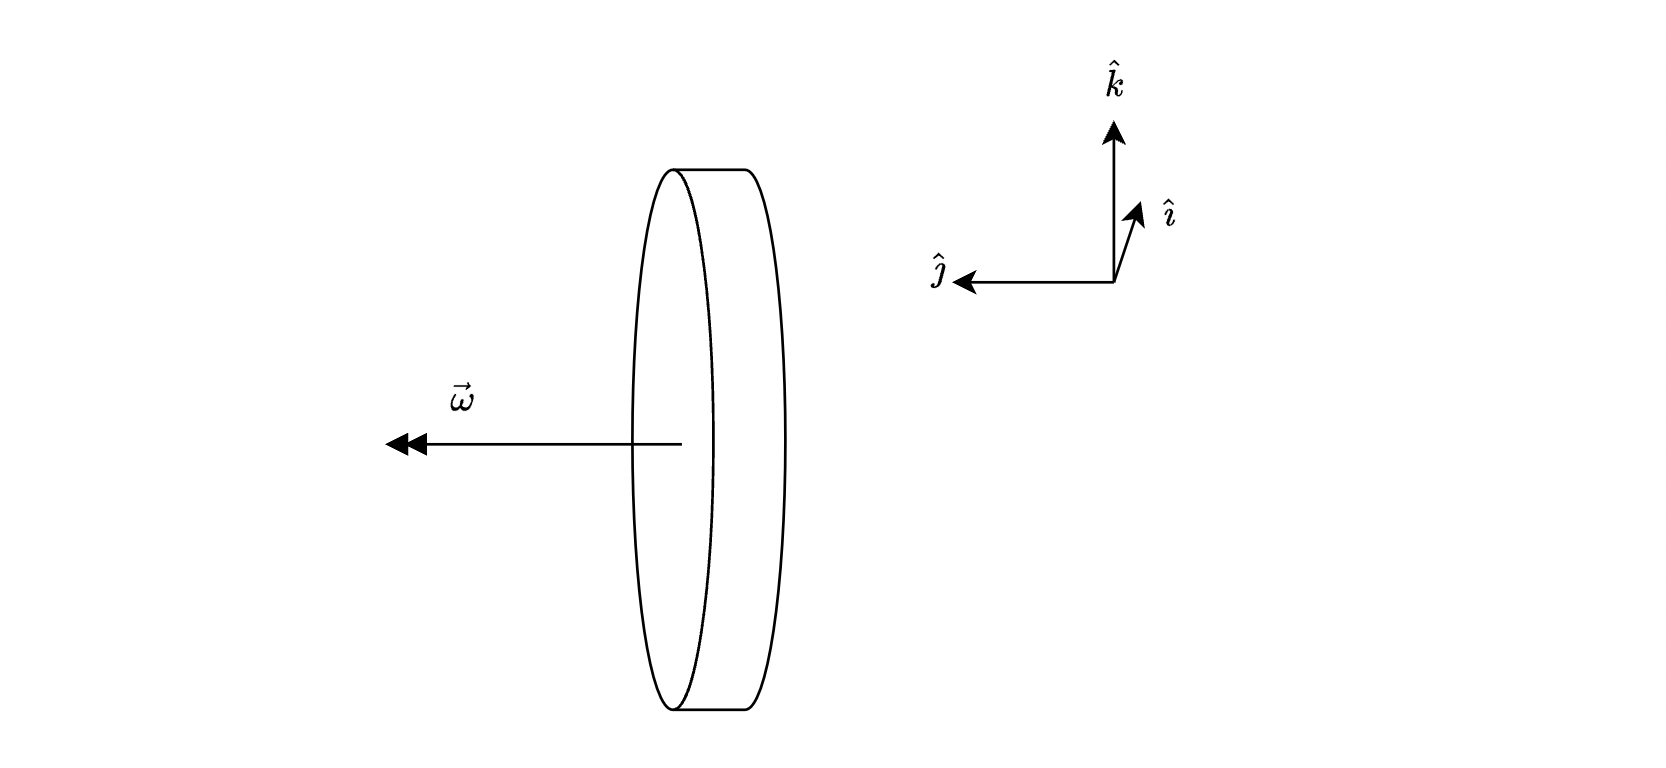

This means we can write the rear wheel's angular momentum as: